In [1]:
import os
from pathlib import Path
import IPython.display as ipd
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime, timedelta
import tensorflow as tf
import seaborn as sns
import subprocess
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "28x28"

# VARS
target_label = "Label"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_UDR{}_THRESH{:5.3f}_DROP{}_LR{}_S{}_B{}{}.csv"
IMG_EXT = ".png"
VERBOSE = True
DISPLAY = True
TEST = False
MFCC = False
TPU = False
RESIZE = True
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
TARGET_WIDTH = 28 if RESIZE else INPUT_WIDTH
TARGET_HEIGHT = 28 if RESIZE else INPUT_HEIGHT
DECAY_RATE = 0.9
IMG_CHANNELS = 3
DROPOUT = 0.4
TYPE = "CNN"
DEFAULT_BS = 128 # default batch size
UNK_DROP_RATE = 1.0 # drop 100% of unknown categories

CATEGORY = ["no_voice"]
CHANNELS = [1, 2, 3, 5, 6, 7, 8]
NUMS = ''.join([str(x) for x in CHANNELS])
MONTHS = [8]
DAYS = [11]

if TEST:
    LEARNING_STEPS = 100
    SPP = 4
    LEARNING_RATE = .05
    BATCH_SIZE = 32
    VERBOSITY = 1000
    TEST_SIZE = 1000
    SHUFFLE_SIZE = 64
else:
    LEARNING_STEPS = 5000
    SPP = 200
    LEARNING_RATE = .025
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 256

def curr_time():
    return datetime.now() - timedelta(hours=7) # offset from UTC to PST

ROOT = os.getcwd() + "/"
if CATEGORY[0] == "no_voice":
    RUN_ROOT = ROOT+"NONVOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
else:
    RUN_ROOT = ROOT+"VOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
RUN_ROOT_LOG = RUN_ROOT+"logs/"

# PATHS
paths = {
    "Training":RUN_ROOT+"keepers_{:02}_{:02}_{}.csv".format(MONTHS[0], DAYS[0], NUMS),
    "Model":RUN_ROOT+"model_dir_{}_OUTLIERS/".format(NUMS),
    "Logs":RUN_ROOT_LOG+"{}_{}/".format(NUMS, datetime.strftime(curr_time(), "%b%d%Y_%H%M%S"))
}
paths["Log"] = paths["Logs"] + "log.txt"
if not os.path.isdir(RUN_ROOT):
    os.mkdir(RUN_ROOT)
if not os.path.isdir(RUN_ROOT_LOG):
    os.mkdir(RUN_ROOT_LOG)
if not os.path.isdir(paths["Logs"]):
    os.mkdir(paths["Logs"])

In [2]:
def make_header(s):
    return ("#" * 42) + ("\n{:^42}\n".format(s)) + ("#" * 42)
    
def print_and_log(s):
    with open(paths["Log"], 'a') as log:
        log.write(str(s))
        log.write("\n")
    print(s)
        
def print_and_log_header(s):
    h = make_header(str(s))
    with open(paths["Log"], 'a') as log:
        log.write(h)
        log.write("\n")
    print(h)

In [3]:
def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print_and_log("Start: {}".format(curr_time()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print_and_log("End: {}".format(curr_time()))
    print_and_log("Finished in {}".format(sec_to_str(end - start)))
    return result

def preprocess(samples, sample_rate):
    padded = np.zeros(sample_rate)
    samples = samples[:sample_rate]
    padded[:samples.shape[0]] = samples
    return padded

def select_labels(df, allowed):
    return df[df['Label'].isin(allowed)]
    
def select_categories(df, allowed):
    return df[df['Category'].isin(allowed)]

def select_channels(df, allowed):
    labels = []
    for i in range(1, 9):
        p = "Path{}".format(i)
        if i not in allowed and p in df.columns:
            labels.append()
    return df.drop(labels, axis=1)

def select_days(df, allowed):
    return df[df['Day'].isin(allowed)]

def select_months(df, allowed):
    return df[df['Month'].isin(allowed)]

def select_sets(df, allowed):
    return df[df['Set'].isin(allowed)]

def remove_voice(df):
    return df.drop(["Path4"], axis=1)

def str_to_l(x):
    return [int(n) for n in x if n <= '9' and n >= '0']

In [4]:
count = 0
def _parse_function(label, *filenames):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print_and_log("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([1, INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS])
    image = None
    for filename in filenames:
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_image(image_string, channels=IMG_CHANNELS)
        image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
        image_decoded = tf.reshape(image_decoded, expected_shape)
        image_decoded = tf.image.rgb_to_grayscale(image_decoded)
        if RESIZE:
            image_decoded = tf.image.resize_bicubic(image_decoded, [TARGET_HEIGHT, TARGET_WIDTH])
        if image is not None:
            image = tf.concat([image, image_decoded], 3)
        else:
            image = image_decoded
    return image, label

In [5]:
def model_fn(features, labels, mode):
    input_layer = tf.reshape(features, [-1, TARGET_HEIGHT, TARGET_WIDTH, len(CHANNELS)])
    pool = input_layer

    for num_filters in [32, 64]:
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=num_filters,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool = tf.layers.flatten(pool)
    dense = tf.layers.dense(inputs=pool, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=DROPOUT, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=num_labels)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not TPU:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    learning_rate = tf.train.exponential_decay(LEARNING_RATE, tf.train.get_global_step(), SPP, DECAY_RATE, staircase=True)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        if TPU:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [6]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train_helper(steps_per_period):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period)
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    return classifier, t_ll, v_ll, t_acc, v_acc

def train():
    periods = LEARNING_STEPS // SPP
    steps_per_period = LEARNING_STEPS // periods
    t_accs, v_accs = [], []
    t_lls, v_lls = [], []
    print_and_log("Training model...\nMetrics:")
    print_and_log("\tPERIOD\tRATE\tTYPE\tTRAIN.\tVALID.\tTIME")
    for period in range(periods):
        lr = LEARNING_RATE * (DECAY_RATE ** ((period * SPP) / SPP))
        classifier, t_ll, v_ll, t_acc, v_acc = train_helper(steps_per_period)
        print_and_log("\t{}\t{:.5f}\tLgLs\t{:.2f}\t{:.2f}\t{}".format(period, lr, t_ll, v_ll, curr_time()))
        print_and_log("\t\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll)
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    v_accuracy = v_accs[-1]
    return classifier, v_accuracy, t_lls, v_lls, t_accs, v_accs

In [7]:
with open(paths["Log"], 'w') as log:
    log.write(make_header("Starting Script\n"))

In [8]:
# Create variables for the paths
train_csv = paths["Training"]

# Store the labels to train
all_labels = ["yes", "no"]
labels = ["yes", "no", "stop", "unknown"]
num_labels = len(labels) - 1
labels = {x[1]:x[0] for x in enumerate(labels)}
reverse_lookup = {labels[k]:k for k in labels}

In [9]:
# Make the training data
print_and_log_header("MAKING TRAINING DATA")
train_data = pd.read_csv(train_csv)

# Filter the training data
train_data = select_categories(train_data, CATEGORY)
train_data = select_channels(train_data, CHANNELS)
train_data = select_labels(train_data, all_labels)
train_data = select_months(train_data, MONTHS)
train_data = select_days(train_data, DAYS)
# train_data = remove_voice(train_data)

train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data["Label"] = train_data["Label"].map(labels)

if VERBOSE:
    print_and_log_header("TRAIN DATA")
    print_and_log(train_data.describe())
    print_and_log(train_data.head(10))

##########################################
           MAKING TRAINING DATA           
##########################################
##########################################
                TRAIN DATA                
##########################################
       Unnamed: 0    Day       Label  Month  SequenceNumber
count  776.000000  776.0  776.000000  776.0      776.000000
mean   387.500000   11.0    0.511598    8.0      216.029639
std    224.156196    0.0    0.500188    0.0      124.874845
min      0.000000   11.0    0.000000    8.0        0.000000
25%    193.750000   11.0    0.000000    8.0      107.750000
50%    387.500000   11.0    1.000000    8.0      218.000000
75%    581.250000   11.0    1.000000    8.0      323.250000
max    775.000000   11.0    1.000000    8.0      430.000000
   Unnamed: 0  Category  Day  Label  Month  \
0         289  no_voice   11      1      8   
1         453  no_voice   11      0      8   
2         268  no_voice   11      1      8   
3         295  no_

In [10]:
# Grab subset of the data for testing purposes
if TEST:
    train_data = train_data[:TEST_SIZE]

In [11]:
# 80/10/10 training/validation/test split
validation_data = select_sets(train_data, ["Validation"])
test_data = select_sets(train_data, ["Testing"])
train_data = select_sets(train_data, ["Training"])

In [12]:
ids = test_data["Path{}".format(CHANNELS[0])] # store the png filenames for output
if VERBOSE:
    print_and_log_header("IDS")
    print_and_log(ids.describe())
    print_and_log(ids.head(10))

##########################################
                   IDS                    
##########################################
count                                                    77
unique                                                   77
top       /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
freq                                                      1
Name: Path1, dtype: object
0     /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
5     /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
6     /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
12    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
23    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
25    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
32    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
33    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
34    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
42    /home/wesleytocs/DanSubvoc/images_scaled/no_vo...
Name: Path1, dtype: object


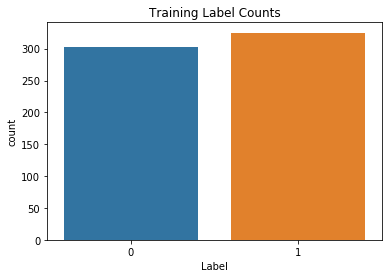

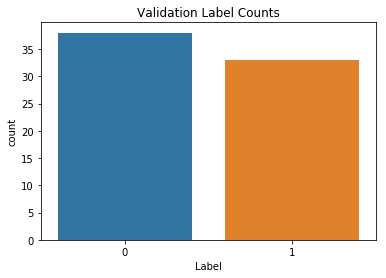

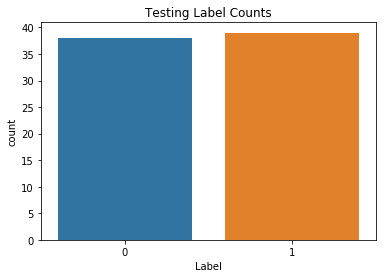

In [13]:
if DISPLAY:
    ax = sns.countplot(x=target_label, data=train_data)
    ax.set_title("Training Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "training_target_counts.jpg")
    plt.show()

    ax = sns.countplot(x=target_label, data=validation_data)
    ax.set_title("Validation Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "validation_target_counts.jpg")
    plt.show()

    ax = sns.countplot(x=target_label, data=test_data)
    ax.set_title("Testing Label Counts")
    ax.get_figure().savefig(paths["Logs"] + "test_target_counts.jpg")
    plt.show()

In [14]:
# Separate Labels
train_labels = train_data.pop(target_label)
validation_labels = validation_data.pop(target_label)
test_labels = test_data.pop(target_label)
img_paths = ["Path{}".format(channel) for channel in CHANNELS]
train_data = train_data[img_paths]
validation_data = validation_data[img_paths]
test_data = test_data[img_paths]

In [15]:
# Sanity check on data
print_and_log_header("TRAINING")
print_and_log(train_data.shape)
print_and_log(type(train_data))
print_and_log(train_labels.shape)
print_and_log(type(train_labels))
print_and_log_header("VALIDATION")
print_and_log(validation_data.shape)
print_and_log(type(validation_data))
print_and_log(validation_labels.shape)
print_and_log(type(validation_labels))
print_and_log_header("TESTING")
print_and_log(test_data.shape)
print_and_log(type(test_data))
print_and_log(test_labels.shape)
print_and_log(type(test_labels))
print_and_log(set(test_labels))

##########################################
                 TRAINING                 
##########################################
(628, 7)
<class 'pandas.core.frame.DataFrame'>
(628,)
<class 'pandas.core.series.Series'>
##########################################
                VALIDATION                
##########################################
(71, 7)
<class 'pandas.core.frame.DataFrame'>
(71,)
<class 'pandas.core.series.Series'>
##########################################
                 TESTING                  
##########################################
(77, 7)
<class 'pandas.core.frame.DataFrame'>
(77,)
<class 'pandas.core.series.Series'>
{0, 1}


In [16]:
# Vectors of filenames.
t_f, v_f, s_f = [], [], []
for i in range(1, 1 + len(CHANNELS)):
    channel = CHANNELS[i-1]
    l = "Path{}".format(channel)
    t_f.append(tf.constant(train_data[l]))
    v_f.append(tf.constant(validation_data[l]))
    s_f.append(tf.constant(test_data[l]))

# `labels[i]` is the label for the image in `filenames[i]
# Vectors of labels
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
test_labels = tf.constant(test_labels)

# Make datasets from filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((train_labels, *t_f))
validation_data = tf.data.Dataset.from_tensor_slices((validation_labels, *v_f))
test_data = tf.data.Dataset.from_tensor_slices((test_labels, *s_f))
print_and_log_header("Parsing Training Data")
train_data = timer(lambda: train_data.map(_parse_function))
print_and_log_header("Parsing Validation Data")
validation_data = timer(lambda: validation_data.map(_parse_function))
print_and_log_header("Parsing Testing Data")
test_data = timer(lambda: test_data.map(_parse_function))
print_and_log("\nDone!")

##########################################
          Parsing Training Data           
##########################################
Start: 2018-08-13 15:24:42.889072
End: 2018-08-13 15:24:43.695478
Finished in 00:00:00:00.805
##########################################
         Parsing Validation Data          
##########################################
Start: 2018-08-13 15:24:43.697603
End: 2018-08-13 15:24:44.637996
Finished in 00:00:00:00.94
##########################################
           Parsing Testing Data           
##########################################
Start: 2018-08-13 15:24:44.640396
End: 2018-08-13 15:24:45.477057
Finished in 00:00:00:00.836

Done!


In [17]:
print_and_log_header("TRAINING")
print_and_log(train_data)
print_and_log(type(train_data))
print_and_log_header("VALIDATION")
print_and_log(validation_data)
print_and_log(type(validation_data))
print_and_log_header("TESTING")
print_and_log(test_data)
print_and_log(type(test_data))

##########################################
                 TRAINING                 
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                VALIDATION                
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                 TESTING                  
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [18]:
# Create the Estimator
if TPU:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        model_dir=paths["Model"],
        config=tf.contrib.tpu.RunConfig(),
        use_tpu=TPU)
else:
    classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=paths["Model"])

In [19]:
# Create the input functions.
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
test_eval_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [20]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2018-08-13 15:24:45.622340
Training model...
Metrics:
	PERIOD	RATE	TYPE	TRAIN.	VALID.	TIME
	0	0.02500	LgLs	0.69	0.70	2018-08-13 15:28:00.193452
			Acc.	51.75%	46.48%

	1	0.02250	LgLs	0.69	0.69	2018-08-13 15:32:00.103652
			Acc.	49.20%	53.52%

	2	0.02025	LgLs	0.69	0.69	2018-08-13 15:36:00.917634
			Acc.	51.43%	56.34%

	3	0.01823	LgLs	0.69	0.69	2018-08-13 15:40:02.352817
			Acc.	63.22%	59.15%

	4	0.01640	LgLs	0.68	0.70	2018-08-13 15:43:52.882254
			Acc.	51.91%	46.48%

	5	0.01476	LgLs	0.69	0.71	2018-08-13 15:47:02.166128
			Acc.	51.91%	46.48%

	6	0.01329	LgLs	0.68	0.70	2018-08-13 15:50:11.820830
			Acc.	51.75%	46.48%

	7	0.01196	LgLs	0.68	0.68	2018-08-13 15:53:23.625960
			Acc.	51.27%	56.34%

	8	0.01076	LgLs	0.67	0.69	2018-08-13 15:56:32.962559
			Acc.	61.78%	50.70%

	9	0.00969	LgLs	0.67	0.70	2018-08-13 15:59:43.227574
			Acc.	52.71%	46.48%

	10	0.00872	LgLs	0.65	0.67	2018-08-13 16:02:53.476528
			Acc.	70.22%	67.61%

	11	0.00785	LgLs	0.64	0.67	2018-08-13 16:06:04.829971
			Acc.	68.

Final accuracy (on validation data): 73.2394%


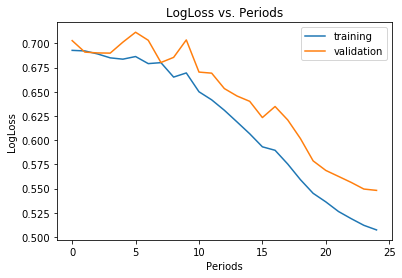

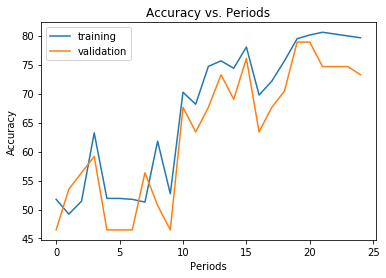

In [21]:
print_and_log("Final accuracy (on validation data): {:.4f}%".format(accuracy))

if DISPLAY:
    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "loss.jpg")

    # Output a graph of accuracy over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "accuracy.jpg")

In [22]:
test_stats = classifier.evaluate(input_fn=test_eval_input_fn)
t_ll = test_stats["loss"]
t_acc = 100 * test_stats["accuracy"]
print_and_log_header("TESTING")
print_and_log("\tLog Loss: {:.2f}".format(t_ll))
print_and_log("\tAccuracy: {:.2f}%".format(t_acc))

##########################################
                 TESTING                  
##########################################
	Log Loss: 0.60
	Accuracy: 70.13%
